In [84]:
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.circuit.library import MCMT
from qiskit.visualization import plot_histogram
from ibm_quantum_widgets import draw_circuit
import numpy as np

In [2]:
class CNF():
    def __init__(self):
        self.cluster_num = None
        self.vaiable_num = None
        self.cnf = None
        self.or_number =None
    def read_file(self,path):
        self.cnf = []
        self.or_number =0       
        with open(path, 'r') as f:
            for line in f:
                if line.startswith("p"):
                    self.vaiable_num = list(map(int, line.split()[-2]))[0]
                    self.cluster_num = list(map(int, line.split()[-1]))[0]
                else:
                    item = list(map(int, line.split()[:-1]))
                    self.cnf.append(item)
                    self.or_number += len(item)-1
    def print_cnf(self):
        print(self.cnf)

In [80]:
class builder():
    def __init__(self):
        self.circuit = None
        
    def build(self,path):
        c = CNF()
        c.read_file(path)
        self.initial_circuit(c)
        draw_circuit(qc.circuit)
        self.build_oracle(c)
        draw_circuit(self.circuit)
        for i in range(c.vaiable_num):
            self.circuit.x(i)
        cnz = MCMT('z', num_ctrl_qubits=c.vaiable_num - 1, num_target_qubits=1)
        self.circuit.append(cnz, [i for i in range(c.vaiable_num)])
        for i in range(c.vaiable_num):
            self.circuit.x(i)
        for i in range(c.vaiable_num):
            self.circuit.h(i)
        self.circuit.measure([i for i in range(c.vaiable_num)], [i for i in range(c.vaiable_num)])
        draw_circuit(self.circuit)
        
        
    def initial_circuit(self,cnf):
        number_of_qubits = cnf.or_number+cnf.vaiable_num+1
        self.circuit = QuantumCircuit(number_of_qubits, cnf.vaiable_num)
        for i in range(cnf.vaiable_num):
            self.circuit.h(i)
        self.circuit.x(number_of_qubits-1)
        self.circuit.h(number_of_qubits-1)
        
    def or_gate(self,a,b,current,gate_list):
        if a < 0:
            gate_list.append(['x', abs(a)-1])
        if b < 0:
            gate_list.append(['x', abs(b)-1])
        gate_list.append(['mcx',[abs(a)-1,abs(b)-1],current-1])
        gate_list.append(['cx', abs(a)-1,current-1])
        gate_list.append(['cx', abs(b)-1,current-1])
        if a < 0:
            gate_list.append(['x', abs(a)-1])
        if b < 0:
            gate_list.append(['x', abs(b)-1])
        return gate_list

    def build_oracle(self,cnf):
        vn = cnf.vaiable_num
        cn = cnf.cluster_num
        and_qubit = []
        oracle = []
        current = vn+1 #the start of or qubit
        ancilla = cnf.vaiable_num+cnf.or_number+1
        for i in range(cn):
            for j in range(len(cnf.cnf[i])):
                if len(cnf.cnf[i]) == 1:
                    and_qubit.append(cnf.cnf[i][0])
                    continue
                if j+1 < len(cnf.cnf[i]):
                    if j == 0:
                        oracle = self.or_gate(cnf.cnf[i][j],cnf.cnf[i][j+1],current,oracle)
                        current+=1
                    else:
                        oracle = self.or_gate(current-1, cnf.cnf[i][j + 1], current, oracle)
                        current += 1
                if j+1 == len(cnf.cnf[i]):
                        and_qubit.append(current-1)
        and_not =False
        for i in and_qubit:
            if i < 0:
                and_not = True
                oracle.append(['x',abs(i)-1])
        oracle.append(['mcx',[abs(x)-1 for x in and_qubit],ancilla-1])
        for i in and_qubit:
            if i < 0:
                oracle.append(['x',abs(i)-1])
        if and_not:
            oracle = oracle + [oracle[i] for i in range(len(oracle)-4,-1, -1)]
        else:
            oracle = oracle + [oracle[i] for i in range(len(oracle)-2,-1, -1)]
        print(oracle)
        for i in oracle:
            if len(i) == 2:
                getattr(self.circuit, i[0])(i[1])
            if len(i) == 3:
                getattr(self.circuit, i[0])(i[1],i[2])
        for i in range(cnf.vaiable_num):
            self.circuit.h(i)
        self.circuit.h(ancilla-1)



                    

In [81]:
qc = builder()
qc.build('test.txt')
qc.circuit.draw()
print(qc.circuit.qasm())

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fc58f54ef70>, editable=Fals…

[['mcx', [0, 1], 2], ['cx', 0, 2], ['cx', 1, 2], ['x', 1], ['mcx', [0, 1], 3], ['cx', 0, 3], ['cx', 1, 3], ['x', 1], ['x', 0], ['mcx', [0, 1], 4], ['cx', 0, 4], ['cx', 1, 4], ['x', 0], ['mcx', [2, 3, 4], 5], ['x', 0], ['cx', 1, 4], ['cx', 0, 4], ['mcx', [0, 1], 4], ['x', 0], ['x', 1], ['cx', 1, 3], ['cx', 0, 3], ['mcx', [0, 1], 3], ['x', 1], ['cx', 1, 2], ['cx', 0, 2], ['mcx', [0, 1], 2]]


CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fc58f54ef70>, editable=Fals…

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fc58f54ef70>, editable=Fals…

OPENQASM 2.0;
include "qelib1.inc";
gate mcx q0,q1,q2,q3 { h q3; p(pi/8) q0; p(pi/8) q1; p(pi/8) q2; p(pi/8) q3; cx q0,q1; p(-pi/8) q1; cx q0,q1; cx q1,q2; p(-pi/8) q2; cx q0,q2; p(pi/8) q2; cx q1,q2; p(-pi/8) q2; cx q0,q2; cx q2,q3; p(-pi/8) q3; cx q1,q3; p(pi/8) q3; cx q2,q3; p(-pi/8) q3; cx q0,q3; p(pi/8) q3; cx q2,q3; p(-pi/8) q3; cx q1,q3; p(pi/8) q3; cx q2,q3; p(-pi/8) q3; cx q0,q3; h q3; }
gate mcmt q0,q1 { cz q0,q1; }
qreg q[6];
creg c[2];
h q[0];
h q[1];
x q[5];
h q[5];
ccx q[0],q[1],q[2];
cx q[0],q[2];
cx q[1],q[2];
x q[1];
ccx q[0],q[1],q[3];
cx q[0],q[3];
cx q[1],q[3];
x q[1];
x q[0];
ccx q[0],q[1],q[4];
cx q[0],q[4];
cx q[1],q[4];
x q[0];
mcx q[2],q[3],q[4],q[5];
x q[0];
cx q[1],q[4];
cx q[0],q[4];
ccx q[0],q[1],q[4];
x q[0];
x q[1];
cx q[1],q[3];
cx q[0],q[3];
ccx q[0],q[1],q[3];
x q[1];
cx q[1],q[2];
cx q[0],q[2];
ccx q[0],q[1],q[2];
h q[0];
h q[1];
h q[5];
x q[0];
x q[1];
mcmt q[0],q[1];
x q[0];
x q[1];
h q[0];
h q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];



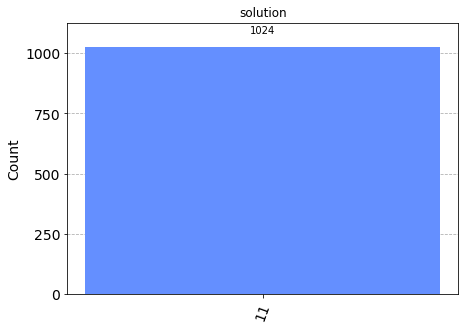

In [87]:
simulator = Aer.get_backend('aer_simulator')
compiled_circuit = transpile(qc.circuit, simulator)
result = simulator.run(compiled_circuit).result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts,title = "solution")


Traceback (most recent call last):
  Input In [89] in <cell line: 5>
    job = service.run(program_id="SAT1",
  File /opt/conda/lib/python3.8/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:959 in run
    raise RuntimeProgramNotFound(
RuntimeProgramNotFound: 'Program not found: 404 Client Error: Not Found for url: https://runtime-us-east.quantum-computing.ibm.com/jobs. {"errors":[{"code":"not_found","message":"program not found","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"ceifujliuboftdmt6q0g"}'

Use %tb to get the full traceback.
